# Exploration of `ExPeCoN`

Running analyses and simulations of `ExPeCoN`

___

    Author:  Carina Forster et al.
    Contact: forster@cbs.mpg.de
    Years:   2023

___

## Setup 

In [1]:
# Import my expecon_ms package and other modules
from pathlib import Path

from expecon_ms.configs import config, params, path_to


***********************************************************************************************
***********************************************************************************************

										expecon_ms

***********************************************************************************************
***********************************************************************************************

Current working dir:	e:\expecon_ms\code\notebooks
New working dir: 'E:\expecon_ms'



In [2]:
# Set global vars & paths

# this doesn't work for some reason
# the variables set here are not recognized in the functions

# raw concatenated eeg data
save_dir_concatenated_raw1 = Path(path_to.data.eeg.RAW_expecon1)
save_dir_concatenated_raw2 = Path(path_to.data.eeg.RAW_expecon2)
save_dir_concatenated_raw1.mkdir(parents=True, exist_ok=True)
save_dir_concatenated_raw2.mkdir(parents=True, exist_ok=True)

# stimulus locked
save_dir_stim_1 = Path(path_to.data.eeg.preprocessed.stimulus_expecon1)
save_dir_stim_2 = Path(path_to.data.eeg.preprocessed.stimulus_expecon2)
save_dir_stim_1.mkdir(parents=True, exist_ok=True)
save_dir_stim_2.mkdir(parents=True, exist_ok=True)

# cue locked
save_dir_cue_1 = Path(path_to.data.eeg.preprocessed.cue_expecon1)
save_dir_cue_2 = Path(path_to.data.eeg.preprocessed.cue_expecon2)
save_dir_cue_1.mkdir(parents=True, exist_ok=True)
save_dir_cue_2.mkdir(parents=True, exist_ok=True)

# directory that contains the cleaned epochs
dir_clean_epochs_expecon1 = Path(path_to.data.eeg.preprocessed.ica.clean_epochs_expecon1)
dir_clean_epochs_expecon2 = Path(path_to.data.eeg.preprocessed.ica.clean_epochs_expecon2)

# EEG cap layout file
filename_montage = Path(path_to.data.templates)
filename_montage.mkdir(parents=True, exist_ok=True)

# raw behavioral data
behav_path = Path(path_to.data.behavior)
behav_path.mkdir(parents=True, exist_ok=True)

# participant IDs
id_list_expecon1 = config.participants.ID_list_expecon1
id_list_expecon2 = config.participants.ID_list_expecon2

# pilot data counter (for expecon 1, participant ID starts with ID007)
pilot_counter = config.participants.pilot_counter

# data_cleaning parameters defined in config.toml
rt_max = config.behavioral_cleaning.rt_max
rt_min = config.behavioral_cleaning.rt_min
hitrate_max = config.behavioral_cleaning.hitrate_max
hitrate_min = config.behavioral_cleaning.hitrate_min
farate_max = config.behavioral_cleaning.farate_max
hit_fa_diff = config.behavioral_cleaning.hit_fa_diff

## Analyse 

1. Preprocessing

In [3]:
# Import functions from expecon_package for data analysis
from expecon_ms.eeg.preprocessing import prepro as pp
from expecon_ms.eeg.preprocessing import ica

Last Commit Date for E:\expecon_ms\code\expecon_ms\eeg\preprocessing\prepro.py : Mon Dec 18 12:03:39 2023 +1000
Last Commit Date for E:\expecon_ms\code\expecon_ms\eeg\preprocessing\ica.py : Tue Dec 19 20:18:03 2023 +1000


In [ ]:
# function expects a raw object with .fif file ending
pp.prepro(study=2, trigger='stimulus', l_freq=1, h_freq=40, tmin=-1,
        tmax=1, resample_rate=250,
        sf=2500, detrend=1, ransac=1, autoreject=0)

# how many channels were interpolated?
pp.n_channels_interpolated(study=2, trigger='stimulus', l_freq=0.1)

# run ica on clean, epoched data
ica.run_ica(study=2, infomax=1, save_psd=1)
# correlate with EOG and ECG and mark bad componets for rejection

ica.label_ica_correlation(study=2)

# usa icalabel to mark components for rejection
#ica.label_iclabel(study=1)

ICA stats

In [6]:
import pandas as pd

# how many components did we reject for study 1 and 2?
#df = pd.read_csv("E:\expecon_ms\data\eeg\prepro_ica\clean_epochs_corr1\ica_components_stats_icacorr.csv")
df = pd.read_csv("E:\expecon_ms\data\eeg\prepro_ica\clean_epochs_corr2\ica_components_stats_icacorr.csv")

# mean components rejected
print(f' on average {df["0"].mean()} components were rejected')
print(f' the sdt of components rejected is {df["0"].std()}')
print(f' the maximum of components rejected is {df["0"].max()}')
print(f' the minimum of components rejected is {df["0"].min()}')

 on average 3.5384615384615383 components were rejected
 the sdt of components rejected is 1.1663292359534148
 the maximum of components rejected is 6
 the minimum of components rejected is 1


2. Evoked potentials

In [7]:
# import relevant functions from expecon_ms
from expecon_ms.eeg.sensor import evokeds as evo

Last Commit Date for E:\expecon_ms\code\expecon_ms\eeg\sensor\evokeds.py : Tue Dec 19 12:28:29 2023 +1000


In [ ]:
# compare evokeds and plot contrasts
evokeds = evo.create_contrast(study=2, drop_bads=True, laplace=False,
                              subtract_evoked=False, save_data_to_disk=False,
                              save_drop_log=False)

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

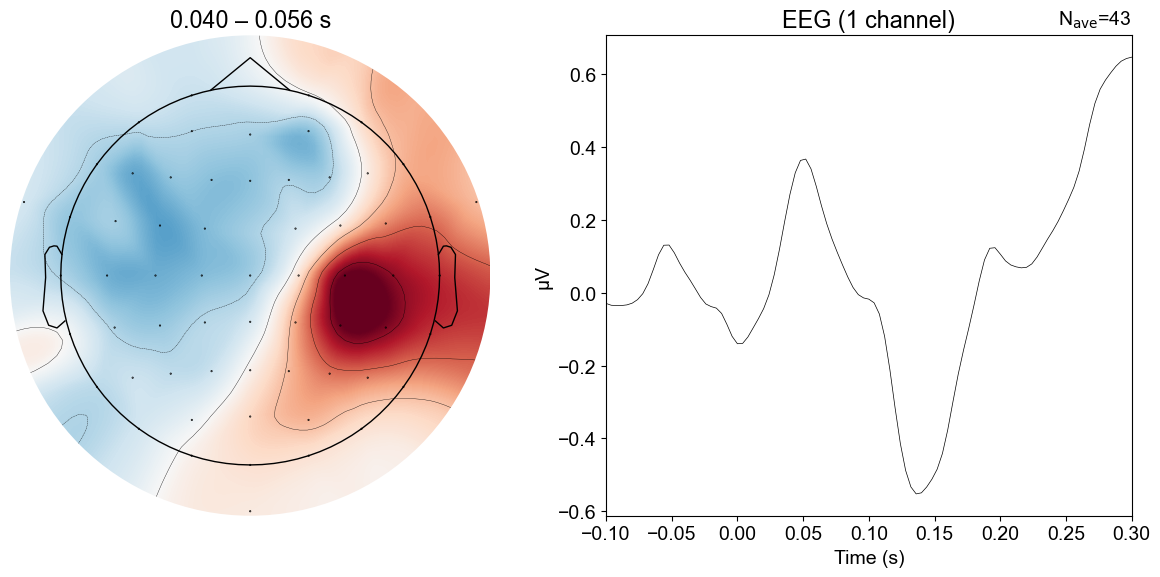

In [4]:
# plot evoked contrast and topography for the contrast
evo.plot_roi(study=2, data=evokeds, tmin=-0.1, tmax=0.3, tmin_base=-0.1, tmax_base=0)

3. Time-frequency analysis

In [2]:
# import relevant functions from expecon_ms
from expecon_ms.eeg.sensor import tfr_contrasts as tfr

Last Commit Date for E:\expecon_ms\code\expecon_ms\eeg\sensor\tfr_contrasts.py : Wed Dec 20 10:51:55 2023 +1000


In [3]:
# compute tfr representations for each condition
tfr.compute_tfr(study=1, cond='probability', tmin=-0.4, tmax=0, fmax=35,
 fmin=3, laplace=False, induced=False, mirror=True, drop_bads=True)

Analyzing 007
Reading E:\expecon_ms\data\eeg\prepro_ica\clean_epochs_corr1\P007_icacorr_0.1Hz-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...     996.00 ms
        0 CTF compensation matrices available
Adding metadata with 17 columns
719 matching events found
No baseline correction applied
0 projection items activated
Removed trials based on reaction time:  0
Mean hit rate: 0.43
Blocks with hit rates > 0.9 or < 0.2:  0
Blocks with false alarm rates > 0.4:  0
Blocks with hit rates < false alarm rates:  0
Replacing existing metadata with 19 columns
Replacing existing metadata with 18 columns
Replacing existing metadata with 30 columns
    Rejecting  epoch based on EEG : ['FT9', 'F6']
1 bad epochs dropped
Not setting metadata
718 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 30 columns
Dropped 0 epochs: 
Dropped 2 epochs: 11, 12
TFR already exists
TFR already exists
Analyzing 008
Reading E:\expecon_ms\data\eeg

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:   22.1s finished


Adding metadata with 30 columns
Analyzing 032
Reading E:\expecon_ms\data\eeg\prepro_ica\clean_epochs_corr1\P032_icacorr_0.1Hz-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...     996.00 ms
        0 CTF compensation matrices available
Adding metadata with 17 columns
720 matching events found
No baseline correction applied
0 projection items activated
Removed trials based on reaction time:  0
Mean hit rate: 0.74
Blocks with hit rates > 0.9 or < 0.2:  2
Blocks with false alarm rates > 0.4:  0
Blocks with hit rates < false alarm rates:  0
Replacing existing metadata with 19 columns
Replacing existing metadata with 18 columns
Replacing existing metadata with 30 columns
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
1 bad epochs dropped
Not setting metadata
431 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 30 columns
Dropped 0 epochs: 
Dropped 1 epoch: 108
TFR already exists
TFR already exists
Analyzing 033
R

('Done with tfr/erp computation', 'high_prevhit_mirror', 'low_mirror')

stimulus probability contrast

In [3]:
# load the tfr data for each condition for probability conds.

tfr_a_cond, tfr_b_cond = tfr.load_tfr_conds(studies=[1, 2], cond='probability',
                                            cond_a_name='high_mirror',
                                            cond_b_name='low_mirror',
                                            cond_a_names=['high_prevhit_mirror',
                                                          'high_prevmiss_mirror',
                                                          'high_prevcr_mirror'],
                                            cond_b_names=['low_prevhit_mirror',
                                                          'low_prevmiss_mirror',
                                                          'low_prevcr_mirror'])

Reading E:\expecon_ms\data\eeg\sensor\tfr\tfr_contrasts\007_high_prevhit_mirror_1-tfr.h5 ...
Reading E:\expecon_ms\data\eeg\sensor\tfr\tfr_contrasts\007_low_prevhit_mirror_1-tfr.h5 ...
Reading E:\expecon_ms\data\eeg\sensor\tfr\tfr_contrasts\007_high_prevmiss_mirror_1-tfr.h5 ...
Reading E:\expecon_ms\data\eeg\sensor\tfr\tfr_contrasts\007_low_prevmiss_mirror_1-tfr.h5 ...
Reading E:\expecon_ms\data\eeg\sensor\tfr\tfr_contrasts\007_high_prevcr_mirror_1-tfr.h5 ...
Reading E:\expecon_ms\data\eeg\sensor\tfr\tfr_contrasts\007_low_prevcr_mirror_1-tfr.h5 ...
Reading E:\expecon_ms\data\eeg\sensor\tfr\tfr_contrasts\008_high_prevhit_mirror_1-tfr.h5 ...
Reading E:\expecon_ms\data\eeg\sensor\tfr\tfr_contrasts\008_low_prevhit_mirror_1-tfr.h5 ...
Reading E:\expecon_ms\data\eeg\sensor\tfr\tfr_contrasts\008_high_prevmiss_mirror_1-tfr.h5 ...
Reading E:\expecon_ms\data\eeg\sensor\tfr\tfr_contrasts\008_low_prevmiss_mirror_1-tfr.h5 ...
Reading E:\expecon_ms\data\eeg\sensor\tfr\tfr_contrasts\008_high_prevcr_m

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

smallest cluster p-value: 0.1533
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: p

  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

smallest cluster p-value: 0.0001


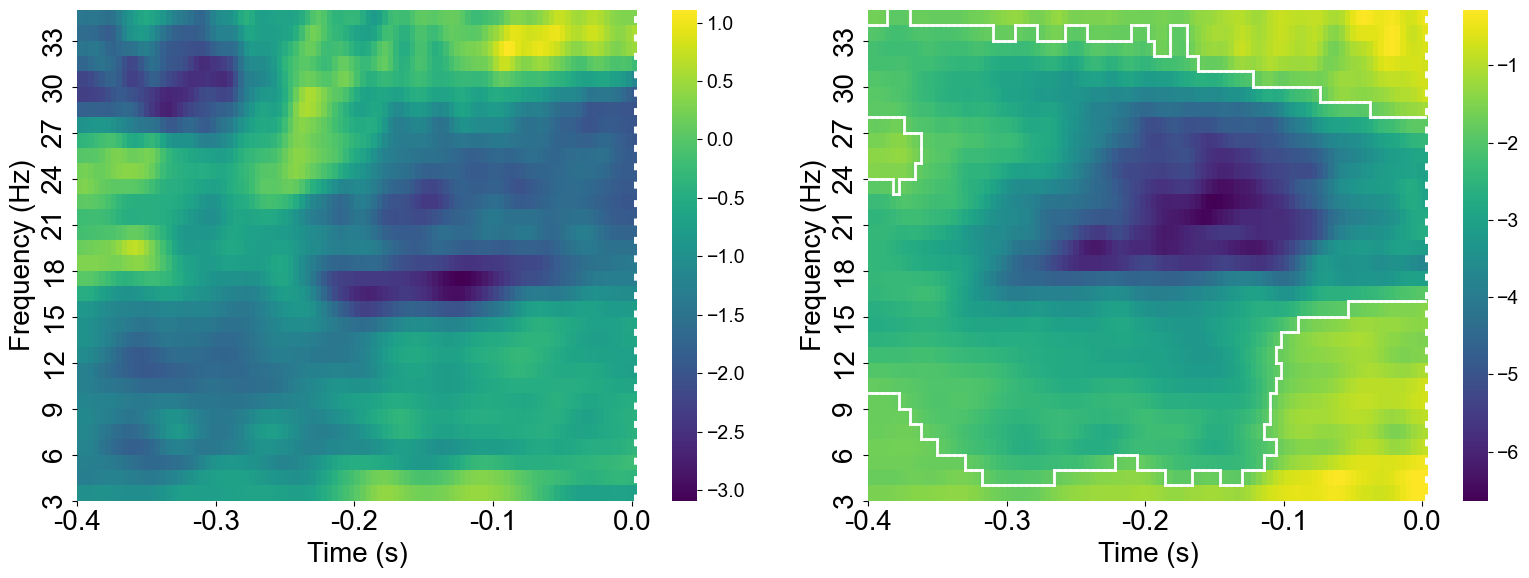

(array([[ -8.26394672,  -8.26394672,  -8.26394672, ...,  -1.70490447,
          -1.13701363,  -1.13701363],
        [ -8.79775027,  -8.79775027,  -8.79775027, ...,  -1.13701363,
          -1.13701363,  -1.13701363],
        [ -8.77129276,  -8.77129276,  -8.77129276, ...,  -2.27138483,
          -2.27138483,  -2.27138483],
        ...,
        [-11.15986107, -11.15986107, -11.60807976, ...,  -3.95778926,
          -3.95778926,  -3.39832523],
        [-10.23290011, -10.23290011, -10.7023679 , ...,  -3.96778926,
          -3.95778926,  -2.8360086 ],
        [ -8.77129276,  -8.77129276,  -8.77129276, ...,  -3.39832523,
          -2.8360086 ,  -2.27138483]]),
 array([0.1 , 0.1 , 0.1 , ..., 0.84, 0.93, 0.98]))

In [4]:
# run cluster based permutation tests for the conditions contrasts
# and plot sign. cluster
tfr.plot_tfr_cluster_test_output(cond='probability', tfr_a_cond=tfr_a_cond, tfr_b_cond=tfr_b_cond,
threed_test=False, cond_a_name='high', cond_b_name='low', channel_names=['CP4'])

previous response contrast

In [ ]:
# load the tfr data for each condition for prev_resp conds.
tfr_a_cond, tfr_b_cond = tfr.load_tfr_conds(studies=[1, 2], cond='prev_resp',
                                            cond_a_name='prevyesresp_highprob_stim_mirror',
                                            cond_b_name='prevnoresp_highprob_stim_mirror',
                                            cond_a_names=None, cond_b_names=None)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

smallest cluster p-value: 0.0191
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: p

  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

smallest cluster p-value: 0.6578


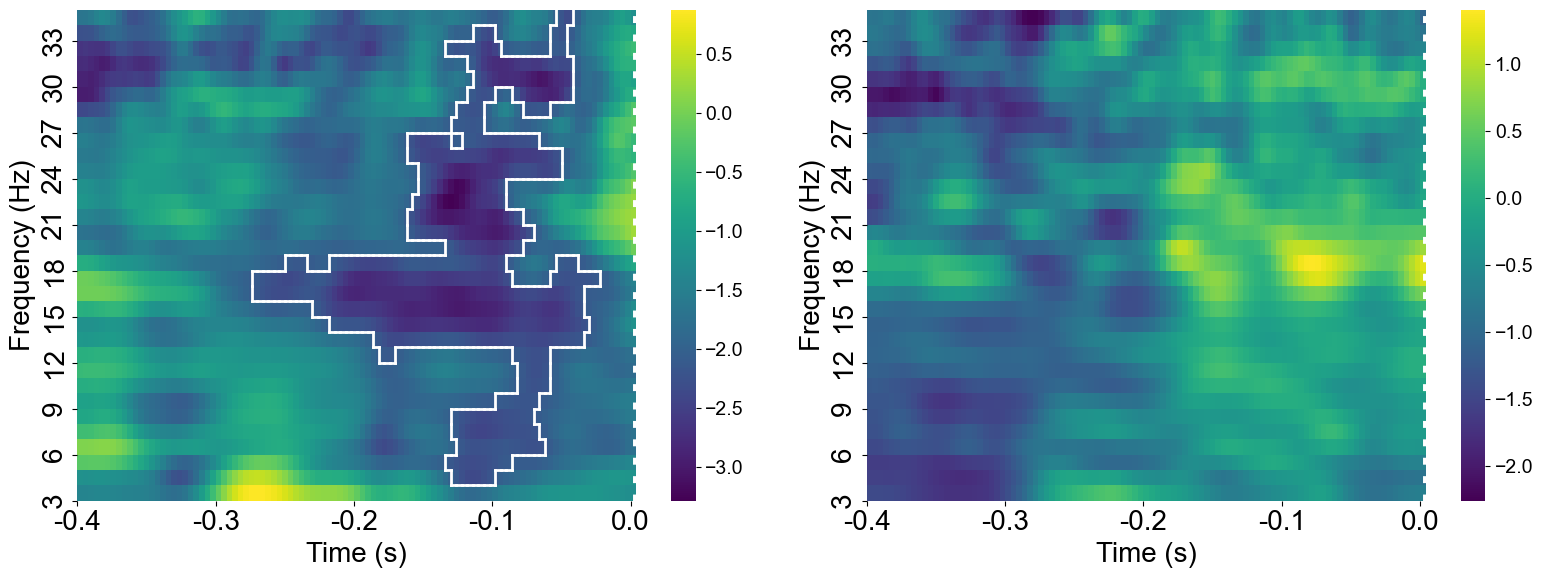

(array([[-4.16348357, -4.16348357, -4.16348357, ..., -1.3489882 ,
         -1.3489882 , -1.29154257],
        [-4.24472396, -4.24472396, -4.24472396, ..., -1.39370956,
         -1.39370956, -1.39370956],
        [-4.26472396, -4.26472396, -4.26472396, ..., -1.29154257,
         -1.29154257, -1.29154257],
        ...,
        [-3.1998889 , -3.38830333, -3.38830333, ..., -1.21638952,
         -1.21638952, -1.16739973],
        [-2.8680757 , -2.8680757 , -3.1998889 , ..., -1.21638952,
         -1.23638952, -1.25053166],
        [-3.1998889 , -3.1998889 , -3.1998889 , ..., -1.21638952,
         -1.23638952, -1.27053166]]),
 array([0.71, 0.71, 0.71, ..., 1.  , 1.  , 1.  ]))

In [8]:
# run cluster based permutation tests for the conditions contrasts
# and plot sign. cluster
tfr.plot_tfr_cluster_test_output(cond='prev_resp', tfr_a_cond=tfr_a_cond, tfr_b_cond=tfr_b_cond,
                                 threed_test=False, cond_a_name='prevyesresp',
                                 cond_b_name='prevnoresp', channel_names=['CP4'])

In [5]:
from expecon_ms.eeg.sensor import tfr_trial

Last Commit Date for E:\expecon_ms\code\expecon_ms\behav\figure1.py : Fri Nov 17 11:05:57 2023 +0100
Last Commit Date for E:\expecon_ms\code\expecon_ms\eeg\sensor\tfr_trial.py : Wed Dec 20 11:51:40 2023 +1000


In [ ]:
# add alpha and beta power per trial to behavioral data and save in csv file for further analysis in R
tfr_trial.save_band_power_per_trial(study=2,
                                    time_intervals={'pre': [(-0.2,0), (-0.3, -0.1)]},
                                    channel_names=['CP4'],
                                    mirror=True)

4. Source reconstruction

In [2]:
# import relevant functions from expecon_ms
from expecon_ms.eeg.source import source_reco

Last Commit Date for E:\expecon_ms\code\expecon_ms\eeg\source\source_reco.py : Mon Dec 18 14:46:56 2023 +1000


In [ ]:
# run source reconstruction for each condition
source_reco.run_source_reco(study=2,
                            cond="probability",
                            mirror=True,
                            dics=True, fmin=15, fmax=25,
                            tmin=-0.4, tmax=0,
                            drop_bads=True,
                            plot_alignment=False)

In [9]:
# plot source contrast (grand average over all participants)
source_reco.plot_grand_average_source_contrast(study=2, cond='prev_resp', method='beamformer')

Permuting 9999 times...
% of significant vertices: 0.001586139580283065
0 files missing from root.txt in C:\Users\Carina\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\Carina\mne_data\MNE-fsaverage-data\fsaverage
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
Using control points [8.48166145e-13 9.15264893e-13 1.60653879e-12]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Usin

### Intermediate summary
Analysis of eeg data showed that in somatosensory regions, prestimulus beta power codes stimulus expectations in the volatile environment. For the stable environment prestimulus beta power codes the previous response. Source reconstruction shows the beta power source for stimulus probability in S2 and for previous responses in posterior cortex and ACC.